**Подключение библиотек и определение нужных функций**

In [144]:
import osmnx as ox
import pandas as pd
import geopandas as gd
import networkx as nx
from scgraph.geographs.marnet import marnet_geograph

''' Определение тегов '''
tags_port = {'industrial' : 'port'}
tags_aeroway = {'aeroway' : ['aerodrome','heliport', 'airstrip']}
tags_landuse = {'landuse' : 'railway'}
tags_build = {'building' : 'warehouse', 'amenity' : 'mailroom'}

''' Построение датафрейма нужных фич '''
def func_tags(tags, city):
    try:
        gdf = ox.features_from_place(city, tags)
    except ox._errors.InsufficientResponseError:
        return None
    gdf = gdf[['name', 'geometry', 'nodes']]
    gdf = gdf.dropna().reset_index()
    gdf['n_osmid'] = gdf['element_type'].apply(lambda x: x[0]) + gdf['osmid'].astype(str)
    ex = [gdf['n_osmid'].apply(lambda x: ox.geocode_to_gdf(x, by_osmid=True)[['lat', 'lon']]).iloc[:].values[x] for x in range(len(gdf))]
    dfs = pd.concat(ex, axis=0).reset_index(drop=True)
    gdf = gdf.merge(dfs, on=dfs.index)
    gdf = gdf.drop('key_0', axis=1)
    gdf = gdf[['name', 'lat', 'lon', 'geometry', 'nodes']]
    gdf['kind_of'] = list(tags.keys())[0]
    return gdf

''' Построение графа, получение датафрейма фич и получение датафрейма долгот и широт для дальшейших вычислений '''
def create_graph_city(name_city, my_network_type = None, my_filter = None):
    full_df = pd.concat([func_tags(tags_port, name_city), 
                                    func_tags(tags_aeroway, name_city), 
                                    func_tags(tags_landuse, name_city), 
                                    func_tags(tags_build, name_city)], ignore_index=True)
    G = ox.graph_from_place(name_city, retain_all=True, simplify = True, network_type = my_network_type, custom_filter = my_filter)

    lat = list(full_df['lat'].values)
    lon = list(full_df['lon'].values)

    return full_df, G, lat, lon

''' Формирование датафрейма фич '''
def create_features_city(features_df, city_graph, lat, lon):
    features_df['new_nodes'] = ox.distance.nearest_nodes(city_graph, lon, lat)
    return features_df

''' Построение bbox '''
def create_graph_several_city(full_graph, my_network_type = None, my_filter = None):
    gdf_nodes, gdf_relationships = ox.graph_to_gdfs(full_graph)
    north, south, east, west = gdf_nodes[['y']].max(), gdf_nodes[['y']].min(), gdf_nodes[['x']].min(), gdf_nodes[['x']].max()
    full_graph_from_bbox = ox.graph_from_bbox(bbox = (north, south, east, west), simplify=True, retain_all=True, network_type = my_network_type, custom_filter = my_filter)
    return full_graph_from_bbox

''' Построение датафрейма долгот и широт для морей и аэро '''
def create_df_to_graphs(kind_of, full_df_from, full_df_to):
    list_lat_aero_from = full_df_from[full_df_from['kind_of'] == kind_of].lat.to_list()
    list_lon_aero_from = full_df_from[full_df_from['kind_of'] == kind_of].lon.to_list()
    list_lat_aero_to = full_df_to[full_df_to['kind_of'] == kind_of].lat.to_list()
    list_lon_aero_to = full_df_to[full_df_to['kind_of'] == kind_of].lon.to_list()
    full_list_lat_aero = list_lat_aero_from + list_lat_aero_to
    full_list_lon_aero = list_lon_aero_from + list_lon_aero_to
    full_df_aero = pd.DataFrame({'x' : full_list_lon_aero, 'y' : full_list_lat_aero})
    return full_df_aero

''' Построение графа по точкам '''
def create_my_graphs(full_graph, full_df_aero):
    full_df_aero['new_nodes'] = ox.distance.nearest_nodes(full_graph, full_df_aero.x, full_df_aero.y)
    full_df_aero['osmid'] = full_df_aero['new_nodes']
    full_df_aero = full_df_aero.set_index('osmid')

    edge_dict = {'u': full_df_aero.new_nodes[:-1].values, 'v': full_df_aero.new_nodes[1:].values, 'key': 0}
    edge_gdf = gd.GeoDataFrame(edge_dict, crs=None)
    edge_gdf = edge_gdf.set_index(['u', 'v', 'key'])

    graph_attrs = {"crs": "WGS84"}
    multi_digraph_aero = ox.graph_from_gdfs(
        full_df_aero, edge_gdf, graph_attrs=graph_attrs)
    
    return multi_digraph_aero

''' Построение воздушного графа '''
def create_graph_aero(full_graph, full_df_from, full_df_to):
    f = create_df_to_graphs('aeroway', full_df_from, full_df_to)
    multi_digraph_aero = create_my_graphs(full_graph, f)
    return multi_digraph_aero

''' Построение морского графа '''
def create_graph_marine(full_g, full_df_from, full_df_to):

    df_marine = create_df_to_graphs('aeroway', full_df_from, full_df_to)
    full_df_marine_x = list(df_marine.x)
    full_df_marine_y = list(df_marine.y)

    for i in range(len(full_df_marine_x)):
        for j in range(i + 1, len(full_df_marine_y)):
            output = (marnet_geograph.get_shortest_path(
                origin_node={"latitude": full_df_marine_y[i],"longitude": full_df_marine_x[i]}, 
                destination_node={"latitude": full_df_marine_y[j],"longitude": full_df_marine_x[j]}
            ))
            list_lat_marine = [output['coordinate_path'][i][0] for i in range(len(output['coordinate_path']))]
            list_lon_marine = [output['coordinate_path'][i][1] for i in range(len(output['coordinate_path']))]
            full_df_marine = pd.DataFrame({'x' : list_lon_marine, 'y' : list_lat_marine})

            multi_digraph_marine = create_my_graphs(full_g, full_df_marine)
            
            full_g = nx.compose_all([full_g, multi_digraph_marine])

    return full_g

In [156]:
def create_graph_route(input_graph, f_df):

    one_route = []
    for i in range(f_df.shape[0]):
        for j in range(i + 1, f_df.shape[0]):
            one_route.append(nx.shortest_path(input_graph, f_df['new_nodes'].iloc[i], f_df['new_nodes'].iloc[j]))

    route_df = pd.DataFrame({'route' : one_route})

    return route_df


def create_final_graph(arb_graph, route_df, feature_df):
    list_graphs = []

    for i in range(route_df.route.shape[0]):
        
        r = route_df['route'].values[i]

        rr = pd.DataFrame({'new_nodes' : r})
        rr['osmid'] = rr['new_nodes']
        rr = rr.set_index('osmid')
        rr['x'] = rr.new_nodes.apply(lambda x: arb_graph.nodes[x]['x'])
        rr['y'] = rr.new_nodes.apply(lambda x: arb_graph.nodes[x]['y'])
        rr

        edge_dict = {'u': rr.new_nodes[:-1].values, 'v': rr.new_nodes[1:].values, 'key': 0}
        edge_gdf = gd.GeoDataFrame(edge_dict, crs=None)
        edge_gdf = edge_gdf.set_index(['u', 'v', 'key'])

        graph_attrs = {"crs": "WGS84"}
        multi_digraph_aero = ox.convert.graph_from_gdfs(
            rr, edge_gdf, graph_attrs=graph_attrs)
        
        list_graphs.append(multi_digraph_aero)
        
    my_graph = list_graphs[0]
    for i in range(1, len(list_graphs)):
        my_graph = nx.compose_all([my_graph, list_graphs[i]])



    nodes, edges = ox.graph_to_gdfs(my_graph)
    list_nodes = list(feature_df['new_nodes'].values)

    n = nodes[nodes['new_nodes'].isin(list_nodes)]
    graph_attrs = {'crs': 'epsg:4326', 'simplified': True}
    g = ox.graph_from_gdfs(n, edges, graph_attrs=graph_attrs)


    return g

___

In [289]:
list_graphs = []

for i in range(route_df.route.shape[0]):
    
    r = route_df['route'].values[i]

    rr = pd.DataFrame({'new_nodes' : r})
    rr['osmid'] = rr['new_nodes']
    rr = rr.set_index('osmid')
    rr['x'] = rr.new_nodes.apply(lambda x: graph_city[1].nodes[x]['x'])
    rr['y'] = rr.new_nodes.apply(lambda x: graph_city[1].nodes[x]['y'])
    rr

    edge_dict = {'u': rr.new_nodes[:-1].values, 'v': rr.new_nodes[1:].values, 'key': 0}
    edge_gdf = gd.GeoDataFrame(edge_dict, crs=None)
    edge_gdf = edge_gdf.set_index(['u', 'v', 'key'])

    graph_attrs = {"crs": "WGS84"}
    multi_digraph_aero = ox.convert.graph_from_gdfs(
        rr, edge_gdf, graph_attrs=graph_attrs)
    
    list_graphs.append(multi_digraph_aero)
    
my_graph = list_graphs[0]
for i in range(1, len(list_graphs)):
    my_graph = nx.compose_all([my_graph, list_graphs[i]])


nodes, edges = ox.graph_to_gdfs(my_graph)
list_nodes = list(feature_df['new_nodes'].values)
n_nodes = nodes[nodes['new_nodes'].isin(list_nodes)]

edge_dict = {'u': n_nodes.new_nodes[:-1].values, 'v': n_nodes.new_nodes[1:].values, 'key': 0}
edge_gdf = gd.GeoDataFrame(edge_dict, crs=None)
edge_gdf = edge_gdf.set_index(['u', 'v', 'key'])
graph_attrs = {'crs': 'epsg:4326', 'simplified': True}
multi_digraph_aero = ox.convert.graph_from_gdfs(
    n_nodes, edge_gdf, graph_attrs=graph_attrs)

# graph_attrs = {'crs': 'epsg:4326', 'simplified': True}
# g = ox.graph_from_gdfs(n, edges, graph_attrs=graph_attrs)

In [297]:
edge_gdf['geometry'] = list_multi_line
multi_digraph_aero = ox.convert.graph_from_gdfs(
    n_nodes, edge_gdf, graph_attrs=graph_attrs)

nodes, edges = ox.graph_to_gdfs(multi_digraph_aero)

In [299]:
edges

,,,geometry
u,v,key,
278364190,6726297219,0,"MULTILINESTRING ((24.70332 59.45996, 24.69975 ..."
6726297219,989935973,0,"MULTILINESTRING ((24.70332 59.45996, 24.69975 ..."
989935973,11780904,0,"MULTILINESTRING ((24.70332 59.45996, 24.69975 ..."
11780904,4622582280,0,"MULTILINESTRING ((24.70332 59.45996, 24.69975 ..."
4622582280,693191997,0,"MULTILINESTRING ((24.70332 59.45996, 24.69975 ..."
693191997,291750883,0,"MULTILINESTRING ((24.70332 59.45996, 24.69975 ..."
291750883,293896194,0,"MULTILINESTRING ((24.70332 59.45996, 24.69975 ..."
293896194,12293081,0,"MULTILINESTRING ((24.70332 59.45996, 24.69975 ..."
12293081,385950102,0,"MULTILINESTRING ((24.70332 59.45996, 24.69975 ..."


In [285]:
from shapely import geometry

ii = 0
list_line = []
list_multi_line = []
for i in range(nn.shape[0] - 1):
    idx = nn.iloc[i + 1].new_nodes
    for j in range(ii + 1, edges.index.get_level_values('u').shape[0]):
        if edges.index.get_level_values('u')[j] != idx:
            list_line.append(edges.loc[edges.index.get_level_values('u')[j]]['geometry'].values[0])
        else : 
            ii = j
    multi_line = geometry.MultiLineString(list_line)
    list_multi_line.append(multi_line)

In [228]:
# ox.plot_graph(multi_digraph_aero)
# nn, ee = ox.graph_to_gdfs(multi_digraph_aero)
nn, ee = ox.graph_to_gdfs(multi_digraph_aero)
edges

geometry
u          v          key                                                   
278364190  11780469   0    LINESTRING (24.70714 59.46191, 24.70332 59.45996)
11780469   632429645  0    LINESTRING (24.70332 59.45996, 24.69975 59.45761)
632429645  8007266402 0    LINESTRING (24.69975 59.45761, 24.70216 59.45391)
8007266402 276653506  0    LINESTRING (24.70216 59.45391, 24.70376 59.45376)
           8007266400 0    LINESTRING (24.70216 59.45391, 24.70375 59.45371)
...                                                                      ...
613185596  613185862  0    LINESTRING (24.83609 59.42928, 24.84081 59.43012)
613185862  59817647   0    LINESTRING (24.84081 59.43012, 24.84747 59.43126)
421670164  906669533  0    LINESTRING (24.76450 59.43734, 24.76450 59.43748)
60294640   278373231  0    LINESTRING (24.75307 59.43712, 24.75358 59.43804)
1403927680 613185635  0    LINESTRING (24.83525 59.42929, 24.83456 59.43004)

[596 rows x 1 columns]

**Построение графа Таллин**

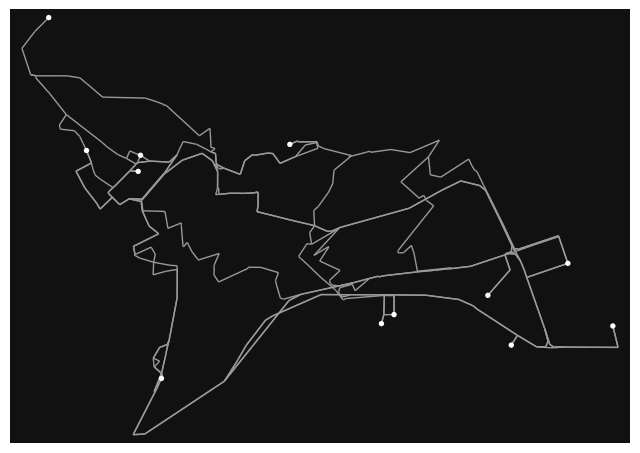

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [159]:
ox.settings.bidirectional_network_types = ["walk", "drive"]

name_city = 'Tallin'
graph_city = create_graph_city(name_city, my_network_type = 'drive')
feature_df = create_features_city(*graph_city)
ox.distance.add_edge_lengths(graph_city[1], edges=None)
route_df = create_graph_route(graph_city[1], feature_df)
final_graph_1_drive = create_final_graph(graph_city[1], route_df, feature_df)
ox.plot_graph(final_graph_1_drive)

___

**Построение Риги**

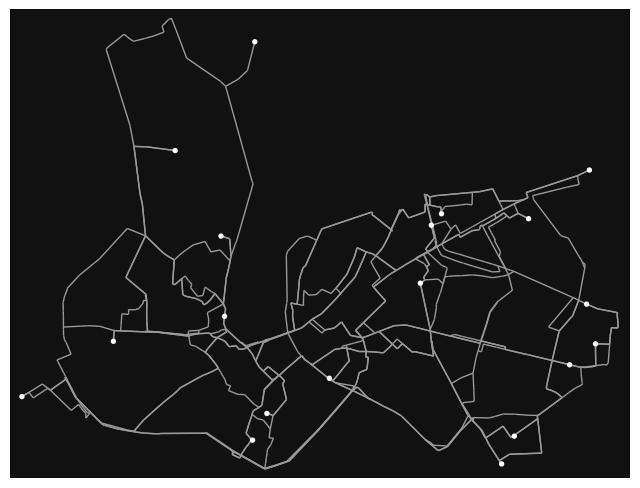

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [133]:
name_city = 'Riga'
graph_city = create_graph_city(name_city, my_network_type = 'drive')
feature_df = create_features_city(*graph_city)
ox.distance.add_edge_lengths(graph_city[1], edges=None)
route_df = create_graph_route(graph_city[1], feature_df)
final_graph_2_drive = create_final_graph(graph_city[1], route_df, feature_df)
ox.plot_graph(final_graph_2_drive)

___

**Соединение двух городов**

In [160]:
# two_city = nx.compose_all([final_graph_1_drive, final_graph_2_drive])
# conn_drive_city = create_graph_several_city(two_city, my_network_type = 'drive')
# conn_feature = create_features_city(conn_drive_city) graph_city[1]  final_graph_1_drive
gdf_nodes, gdf_relationships = ox.graph_to_gdfs(final_graph_1_drive)

KeyError: 'x'

In [149]:
type(final_graph_1_drive)

networkx.classes.multidigraph.MultiDiGraph

In [ ]:
conn_feature

In [ ]:
only_marine_graph_final = create_graph_aero(full_graph, full_df_from, full_df_to)
only_build_to_marine_graph_final = create_final_graph(full_auto_graph, ccc('aeroway', 'building'))
final_marine_graph = nx.compose_all([only_marine_graph_final, only_build_to_marine_graph_final])
ox.plot_graph(final_marine_graph)